In [ ]:
!uv pip install tensorboard

In [13]:
# %load_ext tensorboard


In [ ]:
!uv pip install torch torchvision matplotlib numpy opencv-python tqdm

In [ ]:
from data_roboflow import YoloRoboflowDataset

import torch
from torch.utils.data import DataLoader
from data_roboflow import YoloRoboflowDataset
import matplotlib.pyplot as plt
import config

import utils

# Load the dataset
train_set = YoloRoboflowDataset('train', normalize=False, augment=False)

# Get a random image from the dataset
import random
random_idx = random.randint(0, len(train_set) - 1)
img, label, orig_img = train_set[random_idx]

# Display the random image with bounding boxes
plt.figure(figsize=(12, 8))
plt.imshow(orig_img.permute(1, 2, 0))  # Convert from CxHxW to HxWxC for display

# Extract bounding boxes from the label
img_height, img_width = config.IMAGE_SIZE[1], config.IMAGE_SIZE[0]
grid_size_x = img_width / config.S
grid_size_y = img_height / config.S

# Draw bounding boxes from the label
for i in range(config.S):
    for j in range(config.S):
        # Check if there's an object in this cell (any bbox has confidence)
        has_object = False
        for b in range(config.B):
            bbox_start = config.C + b * 5
            if label[i, j, bbox_start + 4] > 0:
                has_object = True
                break
                
        if has_object:
            # Get class with highest probability
            class_idx = torch.argmax(label[i, j, :config.C]).item()
            class_names = utils.load_class_array()
            class_name = class_names[class_idx]
            
            # Use the first bbox with confidence > 0
            for b in range(config.B):
                bbox_start = config.C + b * 5
                if label[i, j, bbox_start + 4] > 0:
                    # Get normalized coordinates
                    x_center = label[i, j, bbox_start] * grid_size_x + j * grid_size_x
                    y_center = label[i, j, bbox_start + 1] * grid_size_y + i * grid_size_y
                    width = label[i, j, bbox_start + 2] * img_width
                    height = label[i, j, bbox_start + 3] * img_height
                    
                    # Calculate box corners
                    x_min = x_center - width / 2
                    y_min = y_center - height / 2
                    x_max = x_center + width / 2
                    y_max = y_center + height / 2
                    
                    # Draw rectangle
                    rect = plt.Rectangle((x_min, y_min), width, height, 
                                        linewidth=2, edgecolor='r', facecolor='none')
                    plt.gca().add_patch(rect)
                    
                    # Add label
                    plt.text(x_min, y_min - 5, f"{class_name}", 
                            color='white', fontsize=10, 
                            bbox=dict(facecolor='red', alpha=0.5))
                    break  # Only use the first valid bbox

plt.title(f"Random image from training set (index: {random_idx}) with bounding boxes")
plt.show()

Using most recent model directory: models/yolo_v1/05_09_2025/17_33_36


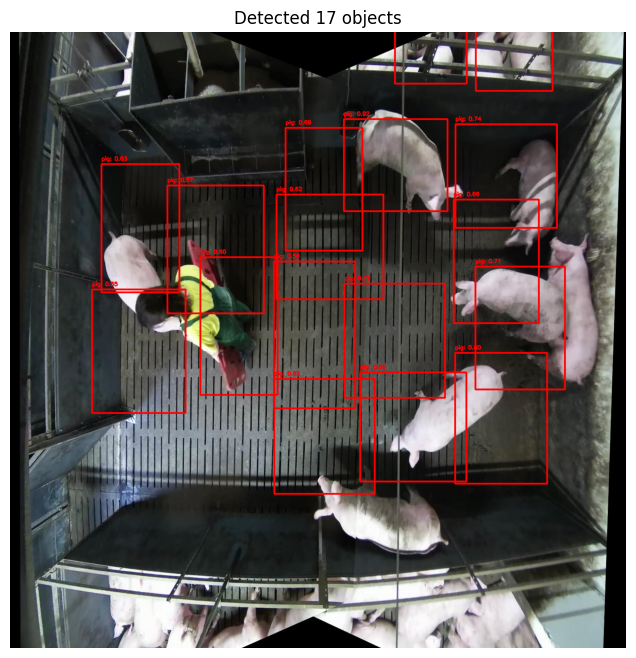

Detection 1: pig (confidence: 0.92) at (921, 240, 1207, 494)
Detection 2: pig (confidence: 0.90) at (1285, -27, 1497, 162)
Detection 3: pig (confidence: 0.80) at (1228, 885, 1482, 1246)
Detection 4: pig (confidence: 0.79) at (923, 694, 1200, 1009)
Detection 5: pig (confidence: 0.74) at (1229, 254, 1509, 540)
Detection 6: pig (confidence: 0.71) at (1284, 647, 1531, 986)
Detection 7: pig (confidence: 0.69) at (760, 264, 972, 603)
Detection 8: pig (confidence: 0.66) at (1224, 462, 1459, 803)
Detection 9: pig (confidence: 0.63) at (252, 364, 467, 718)
Detection 10: pig (confidence: 0.62) at (735, 448, 1030, 737)
Detection 11: pig (confidence: 0.62) at (729, 957, 1006, 1274)
Detection 12: pig (confidence: 0.60) at (1062, -7, 1260, 142)
Detection 13: pig (confidence: 0.60) at (525, 621, 738, 1001)
Detection 14: pig (confidence: 0.59) at (966, 939, 1259, 1240)
Detection 15: pig (confidence: 0.57) at (434, 423, 700, 776)
Detection 16: pig (confidence: 0.56) at (728, 633, 952, 1038)
Detection 1

In [14]:
import torch
import matplotlib.pyplot as plt
import cv2
import os
import torchvision.transforms as T

from models import YOLOv1
import config
import utils
from predict import predict

# Path to model weights
weights_path = ""
base_dir = 'models/yolo_v1'
if os.path.exists(base_dir):
    dates = os.listdir(base_dir)
    if dates:
        latest_date = max(dates)
        times = os.listdir(os.path.join(base_dir, latest_date))
        if times:
            latest_time = max(times)
            weights_path = os.path.join(base_dir, latest_date, latest_time)
            print(f"Using most recent model directory: {weights_path}")

# Load model
model = YOLOv1()
model.load_state_dict(torch.load(os.path.join(weights_path, 'weights', 'final'), map_location=utils.device))
model = model.to(utils.device)
model.eval()

# Path to test image
image_path = "/Users/jamakase/Projects/univ/itmo/cv-adv/cv-advanced-hw/hw3-object-detection-v2/data/valid/Movie_3_frame_000060s_jpg.rf.c0ffa743d232cbc9698956eba89ca034.jpg"

# Load and preprocess the image
confidence_threshold = 0.5
iou_threshold = 0.5
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to tensor and resize to model input size
transform = T.Compose([
    T.ToTensor(),
    T.Resize(config.IMAGE_SIZE)
])
image_tensor = transform(image).unsqueeze(0).to(utils.device)

# Get predictions
batch_detections = utils.predict_and_process(model, image_tensor, confidence_threshold, iou_threshold)
# Since we only have one image, get the first item from the batch
detections = batch_detections[0]

# Draw bounding boxes on the image
draw_img = image.copy()
img_height, img_width = image.shape[:2]

# Get class names
classes = utils.load_class_array()

for det in detections:
    class_idx = det['class_idx']
    score = det['confidence']
    box = det['bbox']
    
    # Convert normalized coordinates to pixel values and to corner format
    x_center, y_center, width, height = box
    x_min = int((x_center - width/2) * img_width)
    y_min = int((y_center - height/2) * img_height)
    x_max = int((x_center + width/2) * img_width)
    y_max = int((y_center + height/2) * img_height)
    
    class_name = classes[class_idx]
    
    # Draw rectangle
    cv2.rectangle(draw_img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 3)
    
    # Add label
    label = f"{class_name}: {score:.2f}"
    cv2.putText(draw_img, label, (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Display results
plt.figure(figsize=(12, 8))
plt.imshow(draw_img)
plt.axis('off')
plt.title(f"Detected {len(detections)} objects")
plt.show()

# Print detections
for i, det in enumerate(detections):
    class_idx = det['class_idx']
    score = det['confidence']
    box = det['bbox']
    class_name = classes[class_idx]
    
    # Convert normalized coordinates to pixel values and to corner format
    x_center, y_center, width, height = box
    x_min = int((x_center - width/2) * img_width)
    y_min = int((y_center - height/2) * img_height)
    x_max = int((x_center + width/2) * img_width)
    y_max = int((y_center + height/2) * img_height)
    
    print(f"Detection {i+1}: {class_name} (confidence: {score:.2f}) at ({x_min}, {y_min}, {x_max}, {y_max})")
